In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Question 2: Classification Using CNN

### Data Loading and Preprocessing

In [4]:
def load_mnist_data(path):
    splits = ['train', 'val', 'test']
    data = {'train': [], 'val': [], 'test': []}
    labels = {'train': [], 'val': [], 'test': []}
    for split in splits:
        split_path = os.path.join(path, split)
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if (int(label) == 0):
                cur_label = 0
            else:
                cur_label = len(label)
            if os.path.isdir(label_path):
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    try:
                        image = Image.open(image_path).convert('L')
                        image_array = np.array(image)
                        data[split].append(image_array)
                        labels[split].append(cur_label)
                    except Exception as e:
                        print(f"Error loading image {image_name}: {e}")
    
    return data['train'], labels['train'], data['val'], labels['val'], data['test'], labels['test']



In [5]:
data_path = "./../../data/external/double_mnist"

train_data, train_labels, val_data, val_labels, test_data, test_labels = load_mnist_data(data_path)

In [6]:
class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, task = 'classification', transform=None):
        self.images = images
        self.labels = labels
        self.task = task
        self.transform = transform
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32) / 255.0
        image = image.unsqueeze(0)

        if self.transform:
            image = self.transform(image)
            
        if (self.task == 'classification'):
            label = torch.tensor(label, dtype=torch.long).to(device)
        elif (self.task == 'regression'):
            label = torch.tensor(label, dtype=torch.float32).to(device).unsqueeze(0)
        return image, label


### Implement the CNN Class

In [7]:
class CNN(nn.Module):
    def __init__(self, task='classification', num_classes=10):
        super(CNN, self).__init__()
        
        self.task = task
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.fc1 = None
        self.fc2 = nn.Linear(128, 64)
        
        if task == 'classification':
            self.fc3 = nn.Linear(64, num_classes)
        elif task == 'regression':
            self.fc3 = nn.Linear(64, 1)

    def _initialize_fc(self, input_shape, device):
        dummy_input = torch.zeros(1, *input_shape).to(device)
        with torch.no_grad():
            output = self._forward_conv(dummy_input)
        flattened_size = output.view(-1).shape[0]
        self.fc1 = nn.Linear(flattened_size, 128).to(device)

    def _forward_conv(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        return x

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x.shape[1:], x.device)

        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            y_pred = self.forward(x)
        return y_pred
    
    def get_accuracy(self, y_pred, y_true):
        if self.task == 'classification':
            y_pred = torch.argmax(y_pred, dim=1)
            return (y_pred == y_true).float().mean()
        elif self.task == 'regression':
            # round to nearest integer
            y_pred = torch.round(y_pred)
            return (y_pred == y_true).float().mean()

    
    def loss(self, y_pred, y_true):
        if self.task == 'classification':
            return F.cross_entropy(y_pred, y_true)
        elif self.task == 'regression':
            return F.mse_loss(y_pred, y_true)

    


In [8]:
def train(model, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        
        for i, (x, y) in train_progress:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = model.loss(y_pred, y)
            loss.backward()
            optimizer.step()
            train_progress.set_postfix({"Loss": f"{loss.item():.4f}"})
        
        model.eval()
        total_accuracy = 0
        total_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                total_loss += model.loss(y_pred, y).item()
                total_accuracy += model.get_accuracy(y_pred, y).item()
                
            avg_loss = total_loss / len(val_loader)
            accuracy = total_accuracy / len(val_loader)
            print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy*100:.2f}%, Validation Loss: {avg_loss:.6f}")


In [9]:
train_data_classification = MultiMNISTDataset(train_data, train_labels)
val_data_classification = MultiMNISTDataset(val_data, val_labels)
test_data_classification = MultiMNISTDataset(test_data, test_labels)

train_loader_classification = DataLoader(train_data_classification, batch_size=32, shuffle=True)
val_loader_classification = DataLoader(val_data_classification, batch_size=32, shuffle=False)
test_loader_classification = DataLoader(test_data_classification, batch_size=32, shuffle=False)

In [10]:
model = CNN(task='classification', num_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, optimizer, train_loader_classification, val_loader_classification, num_epochs=10)

Epoch 1/10: 100%|██████████| 394/394 [00:05<00:00, 65.84it/s, Loss=0.2391]


Epoch 1, Validation Accuracy: 98.18%, Validation Loss: 0.081538


Epoch 2/10: 100%|██████████| 394/394 [00:04<00:00, 85.78it/s, Loss=0.0057]


Epoch 2, Validation Accuracy: 99.34%, Validation Loss: 0.025378


Epoch 3/10: 100%|██████████| 394/394 [00:04<00:00, 86.79it/s, Loss=0.0055]


Epoch 3, Validation Accuracy: 99.22%, Validation Loss: 0.025259


Epoch 4/10: 100%|██████████| 394/394 [00:04<00:00, 85.96it/s, Loss=0.0156]


Epoch 4, Validation Accuracy: 99.77%, Validation Loss: 0.018945


Epoch 5/10: 100%|██████████| 394/394 [00:04<00:00, 87.43it/s, Loss=0.0247]


Epoch 5, Validation Accuracy: 99.70%, Validation Loss: 0.016451


Epoch 6/10: 100%|██████████| 394/394 [00:04<00:00, 83.81it/s, Loss=0.2080]


Epoch 6, Validation Accuracy: 99.47%, Validation Loss: 0.027042


Epoch 7/10: 100%|██████████| 394/394 [00:04<00:00, 85.33it/s, Loss=0.0054]


Epoch 7, Validation Accuracy: 99.83%, Validation Loss: 0.010574


Epoch 8/10: 100%|██████████| 394/394 [00:04<00:00, 79.70it/s, Loss=0.0665]


Epoch 8, Validation Accuracy: 99.53%, Validation Loss: 0.023830


Epoch 9/10: 100%|██████████| 394/394 [00:05<00:00, 66.82it/s, Loss=0.1814]


Epoch 9, Validation Accuracy: 99.83%, Validation Loss: 0.015125


Epoch 10/10: 100%|██████████| 394/394 [00:05<00:00, 74.10it/s, Loss=0.0035]


Epoch 10, Validation Accuracy: 99.83%, Validation Loss: 0.011680


In [11]:
train_data_regression = MultiMNISTDataset(train_data, train_labels, task='regression')
val_data_regression = MultiMNISTDataset(val_data, val_labels, task='regression')
test_data_regression = MultiMNISTDataset(test_data, test_labels, task='regression')

train_loader_regression = DataLoader(train_data_regression, batch_size=32, shuffle=True)
val_loader_regression = DataLoader(val_data_regression, batch_size=32, shuffle=False)
test_loader_regression = DataLoader(test_data_regression, batch_size=32, shuffle=False)

In [12]:
model = CNN(task='regression').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, optimizer, train_loader_regression, val_loader_regression, num_epochs=10)

Epoch 1/10: 100%|██████████| 394/394 [00:05<00:00, 78.39it/s, Loss=0.0599]


Epoch 1, Validation Accuracy: 94.15%, Validation Loss: 0.070379


Epoch 2/10: 100%|██████████| 394/394 [00:05<00:00, 76.16it/s, Loss=0.0269]


Epoch 2, Validation Accuracy: 98.34%, Validation Loss: 0.042677


Epoch 3/10: 100%|██████████| 394/394 [00:05<00:00, 74.42it/s, Loss=0.4474]


Epoch 3, Validation Accuracy: 99.24%, Validation Loss: 0.025254


Epoch 4/10: 100%|██████████| 394/394 [00:05<00:00, 75.14it/s, Loss=0.0468]


Epoch 4, Validation Accuracy: 99.40%, Validation Loss: 0.021515


Epoch 5/10: 100%|██████████| 394/394 [00:05<00:00, 73.06it/s, Loss=0.0179]


Epoch 5, Validation Accuracy: 99.34%, Validation Loss: 0.021339


Epoch 6/10: 100%|██████████| 394/394 [00:05<00:00, 73.13it/s, Loss=0.1576]


Epoch 6, Validation Accuracy: 99.57%, Validation Loss: 0.022488


Epoch 7/10: 100%|██████████| 394/394 [00:05<00:00, 71.85it/s, Loss=0.0156]


Epoch 7, Validation Accuracy: 99.93%, Validation Loss: 0.021447


Epoch 8/10: 100%|██████████| 394/394 [00:05<00:00, 72.29it/s, Loss=0.1350]


Epoch 8, Validation Accuracy: 99.70%, Validation Loss: 0.018109


Epoch 9/10: 100%|██████████| 394/394 [00:05<00:00, 72.67it/s, Loss=0.0128]


Epoch 9, Validation Accuracy: 99.77%, Validation Loss: 0.017381


Epoch 10/10: 100%|██████████| 394/394 [00:05<00:00, 67.75it/s, Loss=0.0223]


Epoch 10, Validation Accuracy: 99.20%, Validation Loss: 0.028246


In [13]:
def load_mnist_data_multilabel(path):
    splits = ['train', 'val', 'test']
    data = {'train': [], 'val': [], 'test': []}
    labels = {'train': [], 'val': [], 'test': []}
    for split in splits:
        split_path = os.path.join(path, split)
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if (int(label) == 0):
                cur_label = []
            else:
                cur_label = [int(i) for i in label]
            if os.path.isdir(label_path):
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    try:
                        image = Image.open(image_path).convert('L')
                        image_array = np.array(image)
                        data[split].append(image_array)
                        labels[split].append(cur_label)
                    except Exception as e:
                        print(f"Error loading image {image_name}: {e}")
    
    return data['train'], labels['train'], data['val'], labels['val'], data['test'], labels['test']

In [14]:
def get_one_hot(y):
    one_hot = np.zeros(30)
    l = len(y)
    for i in range(l):
        one_hot[10*i + y[i]] = 1
    return one_hot

In [15]:
class MultiMNISTDataset_mulitlabel(Dataset):
    def __init__(self, images, labels, task='multilabel_classification', transform=None):
        self.images = images
        self.labels = labels
        self.task = task
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32) / 255.0
        image = image.unsqueeze(0)

        if self.transform:
            image = self.transform(image)

        if self.task == 'multilabel_classification':
            label = torch.tensor(label, dtype=torch.float32).to(device)
        else:
            label = torch.tensor(label, dtype=torch.float32).to(device).unsqueeze(0)
        return image, label


In [16]:
class CNN_Multilabel(nn.Module):
    def __init__(self, task='multilabel_classification', num_classes=30):
        super(CNN_Multilabel, self).__init__()
        
        self.task = task
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.fc1 = None
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def _initialize_fc(self, input_shape, device):
        dummy_input = torch.zeros(1, *input_shape).to(device)
        with torch.no_grad():
            output = self._forward_conv(dummy_input)
        flattened_size = output.view(-1).shape[0]
        self.fc1 = nn.Linear(flattened_size, 128).to(device)

    def _forward_conv(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        return x

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x.shape[1:], x.device)

        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_accuracy(self, y_pred, y_true):
        if self.task == 'multilabel_classification':
            y_pred = torch.sigmoid(y_pred) 
            y_pred = (y_pred > 0.5).float()
            return ((y_pred == y_true).float().mean()).item()
        else:
            return F.mse_loss(y_pred, y_true)

    def loss(self, y_pred, y_true):
        if self.task == 'multilabel_classification':
            return F.binary_cross_entropy_with_logits(y_pred, y_true)
        else:
            return F.mse_loss(y_pred, y_true)


In [17]:
def train_multilabel(model, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        
        for i, (x, y) in train_progress:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = model.loss(y_pred, y)
            loss.backward()
            optimizer.step()
            train_progress.set_postfix({"Loss": f"{loss.item():.4f}"})
        
        model.eval()
        total_accuracy = 0
        total_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                total_loss += model.loss(y_pred, y).item()
                total_accuracy += model.get_accuracy(y_pred, y)

            avg_loss = total_loss / len(val_loader)
            accuracy = total_accuracy / len(val_loader)
            print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy*100:.2f}%, Validation Loss: {avg_loss:.6f}")


In [18]:
train_data_multilabel, train_labels_multilabel, val_data_multilabel, val_labels_multilabel, test_data_multilabel, test_labels_multilabel = load_mnist_data_multilabel(data_path)

In [19]:
train_labels_multilabel_one_hot = [get_one_hot(y) for y in train_labels_multilabel]
val_labels_multilabel_one_hot = [get_one_hot(y) for y in val_labels_multilabel]
test_labels_multilabel_one_hot = [get_one_hot(y) for y in test_labels_multilabel]

In [20]:
train_data_multilabel = MultiMNISTDataset_mulitlabel(train_data_multilabel, train_labels_multilabel_one_hot)
val_data_multilabel = MultiMNISTDataset_mulitlabel(val_data_multilabel, val_labels_multilabel_one_hot)
test_data_multilabel = MultiMNISTDataset_mulitlabel(test_data_multilabel, test_labels_multilabel_one_hot)

train_loader_multilabel = DataLoader(train_data_multilabel, batch_size=32, shuffle=True)
val_loader_multilabel = DataLoader(val_data_multilabel, batch_size=32, shuffle=False)
test_loader_multilabel = DataLoader(test_data_multilabel, batch_size=32, shuffle=False)

In [21]:
model = CNN_Multilabel(task='multilabel_classification', num_classes=30).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_multilabel(model, optimizer, train_loader_multilabel, val_loader_multilabel, num_epochs=10)

Epoch 1/10:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 1/10: 100%|██████████| 394/394 [00:04<00:00, 79.94it/s, Loss=0.2370]


Epoch 1, Validation Accuracy: 93.22%, Validation Loss: 0.237056


Epoch 2/10: 100%|██████████| 394/394 [00:04<00:00, 86.18it/s, Loss=0.2433]


Epoch 2, Validation Accuracy: 93.22%, Validation Loss: 0.227650


Epoch 3/10: 100%|██████████| 394/394 [00:04<00:00, 89.03it/s, Loss=0.1982]


Epoch 3, Validation Accuracy: 93.29%, Validation Loss: 0.226458


Epoch 4/10: 100%|██████████| 394/394 [00:04<00:00, 85.04it/s, Loss=0.2163]


Epoch 4, Validation Accuracy: 93.44%, Validation Loss: 0.236205


Epoch 5/10: 100%|██████████| 394/394 [00:04<00:00, 83.96it/s, Loss=0.1784]


Epoch 5, Validation Accuracy: 93.42%, Validation Loss: 0.221007


Epoch 6/10: 100%|██████████| 394/394 [00:04<00:00, 83.19it/s, Loss=0.1721]


Epoch 6, Validation Accuracy: 93.42%, Validation Loss: 0.214051


Epoch 7/10: 100%|██████████| 394/394 [00:04<00:00, 87.94it/s, Loss=0.1565]


Epoch 7, Validation Accuracy: 93.33%, Validation Loss: 0.213519


Epoch 8/10: 100%|██████████| 394/394 [00:04<00:00, 91.81it/s, Loss=0.1320]


Epoch 8, Validation Accuracy: 93.44%, Validation Loss: 0.215109


Epoch 9/10: 100%|██████████| 394/394 [00:04<00:00, 88.85it/s, Loss=0.1733]


Epoch 9, Validation Accuracy: 93.17%, Validation Loss: 0.220621


Epoch 10/10: 100%|██████████| 394/394 [00:04<00:00, 90.83it/s, Loss=0.1449]


Epoch 10, Validation Accuracy: 93.22%, Validation Loss: 0.216357


## AutoEncoder

In [22]:
ae_train_data_path = "./../../data/external/fashion_mnist/fashion_mnist_train.csv"
ae_test_data_path = "./../../data/external/fashion_mnist/fashion_mnist_test.csv"

ae_train_data = pd.read_csv(ae_train_data_path)
ae_test_data = pd.read_csv(ae_test_data_path)

ae_val_data = ae_train_data.iloc[len(ae_train_data) - len(ae_test_data):]
ae_train_data = ae_train_data.iloc[:len(ae_train_data) - len(ae_test_data)]

ae_train_x = ae_train_data.drop('label', axis=1).values
ae_train_y = ae_train_data['label'].values

ae_val_x = ae_val_data.drop('label', axis=1).values
ae_val_y = ae_val_data['label'].values

ae_test_x = ae_test_data.drop('label', axis=1).values
ae_test_y = ae_test_data['label'].values

ae_train_x = ae_train_x/255.0
ae_val_x = ae_val_x/255.0
ae_test_x = ae_test_x/255.0

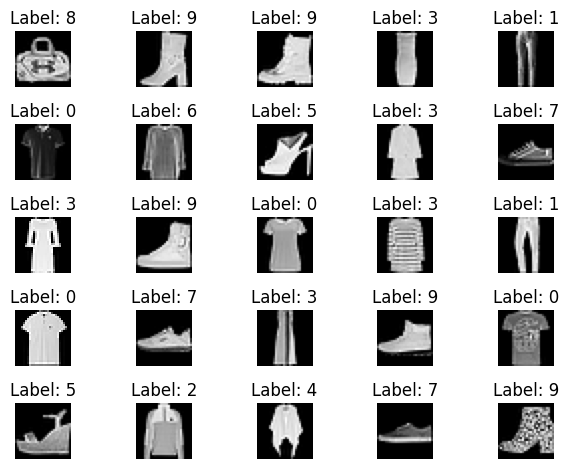

In [23]:
ae_train_data_sample = ae_train_data.sample(25)

ae_images = ae_train_data_sample.drop('label', axis=1).values
ae_labels = ae_train_data_sample['label'].values
ae_labels = ae_labels

ae_images = ae_images.reshape(-1, 28, 28)

ae_images = [Image.fromarray((image).astype(np.uint8)) for image in ae_images]

fig, axes = plt.subplots(5, 5)

for i, ax in enumerate(axes.flat):
    ax.imshow(ae_images[i], cmap='gray')
    ax.set_title(f"Label: {ae_labels[i]}")
    ax.axis('off')

plt.tight_layout()

In [24]:
class CnnAutoencoder(nn.Module):
    def __init__(self):
        super(CnnAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def loss(self, y_pred, y_true):
        return F.mse_loss(y_pred, y_true)

    def evaluate(self, data_loader, device):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for x, _ in data_loader:
                x = x.to(device)
                y_pred = self.forward(x)
                loss = self.loss(y_pred, x)
                total_loss += loss.item()
        return total_loss / len(data_loader)


In [25]:
class MultiMNISTDataset_ae(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image.reshape(-1, 28, 28), dtype=torch.float32)
        return image, label

In [26]:
train_data_ae = MultiMNISTDataset_ae(ae_train_x, ae_train_y)
val_data_ae = MultiMNISTDataset_ae(ae_val_x, ae_val_y)
test_data_ae = MultiMNISTDataset_ae(ae_test_x, ae_test_y)

train_loader_ae = DataLoader(train_data_ae, batch_size=32, shuffle=True)
val_loader_ae = DataLoader(val_data_ae, batch_size=32, shuffle=False)
test_loader_ae = DataLoader(test_data_ae, batch_size=32, shuffle=False)

In [27]:
def train_autoencoder(model, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        
        for i, (x, _) in train_progress:
            x = x.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = model.loss(y_pred, x)
            loss.backward()
            optimizer.step()
            train_progress.set_postfix({"Loss": f"{loss.item():.4f}"})
        
        val_loss = model.evaluate(val_loader, device)
        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.6f}")


In [28]:
autoencoder = CnnAutoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

train_autoencoder(autoencoder, optimizer, train_loader_ae, val_loader_ae, num_epochs=3)

Epoch 1/3: 100%|██████████| 1563/1563 [00:09<00:00, 161.38it/s, Loss=0.0117]


Epoch 1, Validation Loss: 0.012275


Epoch 2/3: 100%|██████████| 1563/1563 [00:08<00:00, 176.38it/s, Loss=0.0091]


Epoch 2, Validation Loss: 0.009272


Epoch 3/3: 100%|██████████| 1563/1563 [00:13<00:00, 113.12it/s, Loss=0.0069]


Epoch 3, Validation Loss: 0.007918


In [29]:
def plot_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)
            y_pred = model(x)
            break

    x = x.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    fig, axes = plt.subplots(2, 10, figsize=(15, 5))
    fig.subplots_adjust(hspace=0.4)
    for i in range(10):
        axes[0, i].imshow(x[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(y_pred[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')
        axes[0, i].set_title("Original")
        axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()


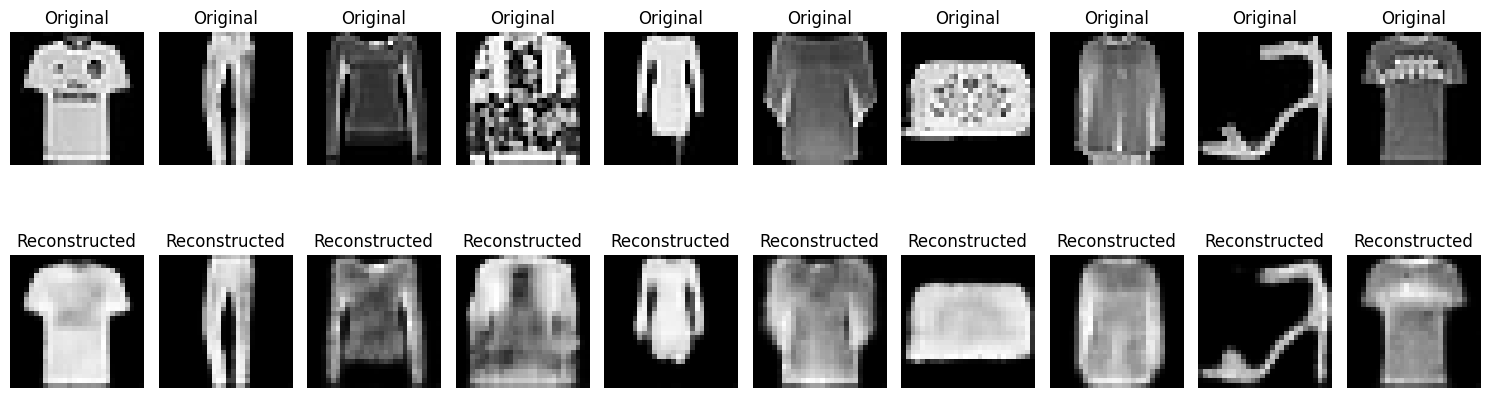

In [30]:
plot_reconstruction(autoencoder, test_loader_ae)

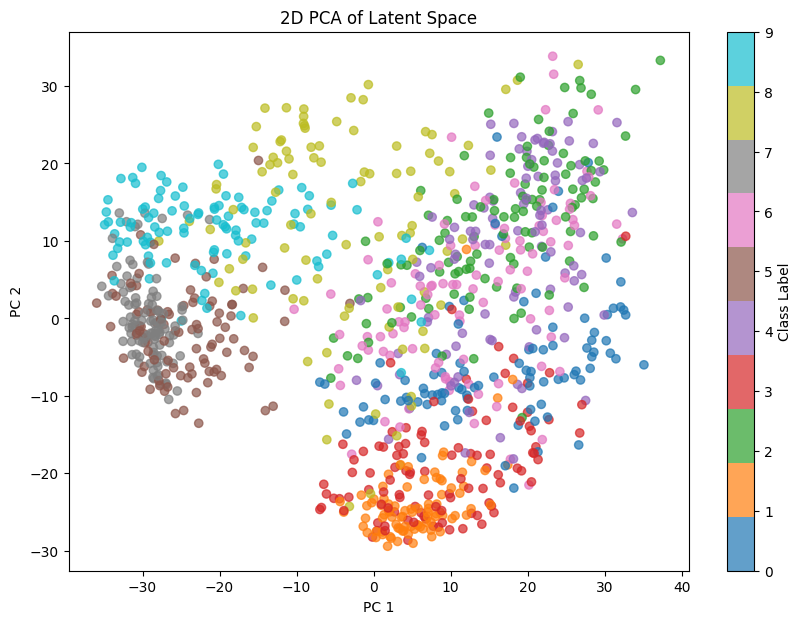

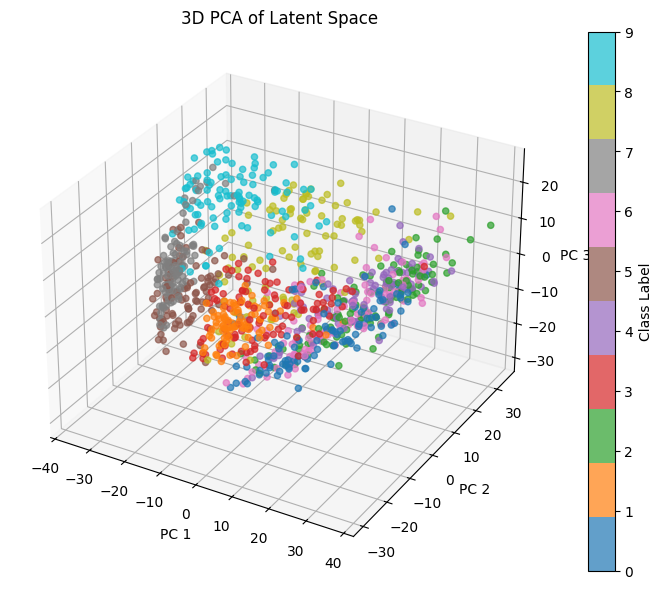

In [31]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def plot_latent_space(model, data_loader, num_samples=1000):
    model.eval()
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            encoded = model.encode(x)
            latent_representations.append(encoded.view(encoded.size(0), -1).cpu().numpy())
            labels.extend(y.cpu().numpy())
            if len(labels) >= num_samples:
                break
    
    latent_representations = np.concatenate(latent_representations)[:num_samples]
    labels = np.array(labels)[:num_samples]
    
    pca_2d = PCA(n_components=2)
    latent_2d = pca_2d.fit_transform(latent_representations)
    
    pca_3d = PCA(n_components=3)
    latent_3d = pca_3d.fit_transform(latent_representations)

    # 2D plot
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Class Label')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("2D PCA of Latent Space")
    plt.show()

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=labels, cmap='tab10', alpha=0.7)
    fig.colorbar(scatter, ax=ax, label='Class Label')
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    plt.title("3D PCA of Latent Space")
    plt.show()

plot_latent_space(autoencoder, test_loader_ae)


### MLP AutoEncoder

In [32]:
import sys
sys.path.append('./../../')

In [33]:
from models.autoencoder.autoencoder import AutoEncoder

input_dim = ae_train_x.shape[1]
latent_dim = 64
neurons_per_layer = [128, 64] 
mlp_autoencoder = AutoEncoder(input_dim=input_dim, latent_dim=latent_dim, 
                              neurons_per_layer=neurons_per_layer, learning_rate=0.001, 
                              n_epochs=50, batch_size=32)

mlp_autoencoder.fit(ae_train_x)

Text(0.5, 1.0, 'Training Loss')

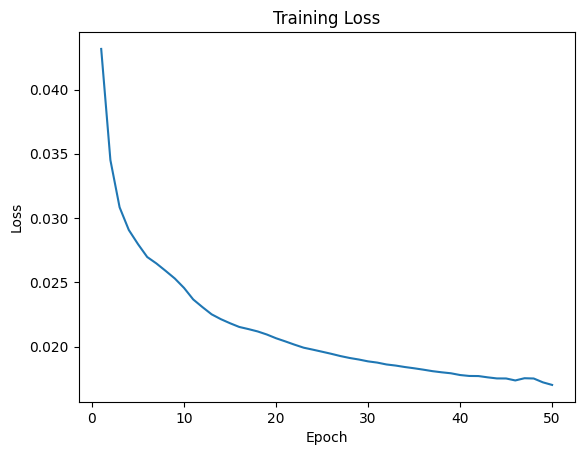

In [34]:
epochs = range(1, mlp_autoencoder.autoencoder.n_epochs + 1)
plt.plot(epochs, mlp_autoencoder.autoencoder.loss_list, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

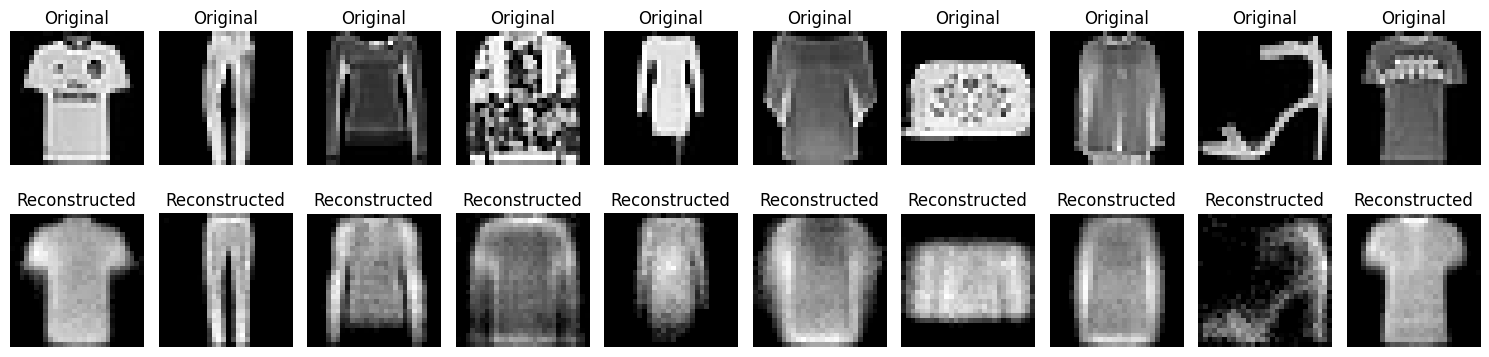

In [35]:
test_reconstructions = mlp_autoencoder.reconstruct(ae_test_x[:10])

original_images = ae_test_x[:10].reshape(-1, 28, 28)
reconstructed_images = test_reconstructions.reshape(-1, 28, 28)

fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(original_images[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()


In [36]:
from models.pca.pca import PCA

class PCA_autoencoder:
    def __init__(self, latent_dim):
        self.latent_dim = latent_dim
        self.pca = PCA(latent_dim)
    
    def fit(self, x):
        self.pca.fit(x)

    def encode(self, x):
        return self.pca.transform(x)

    def forward(self, x):
        x_encoded = self.encode(x)
        return np.dot(x_encoded, self.pca.eig_vectors[:, :self.latent_dim].T) + self.pca.means

In [37]:
def estimate_optimal_components(X_train, X_val, max_components=100):
    mse_errors = []
    component_range = range(1, max_components + 1)

    for n_components in component_range:
        pca_autoencoder = PCA_autoencoder(latent_dim=n_components)
        pca_autoencoder.fit(X_train)
        X_val_reconstructed = pca_autoencoder.forward(X_val)
        mse = np.mean((X_val - X_val_reconstructed) ** 2)
        mse_errors.append(mse)

    plt.plot(component_range, mse_errors)
    plt.xlabel("Number of Components")
    plt.ylabel("Reconstruction Error (MSE)")
    plt.title("Elbow Plot of Reconstruction Error vs Number of Components")
    plt.show()

    k_optimal = component_range[np.argmin(np.gradient(np.gradient(mse_errors)))]
    print(f"Optimal number of components (koptimal): {k_optimal}")

    return k_optimal, mse_errors

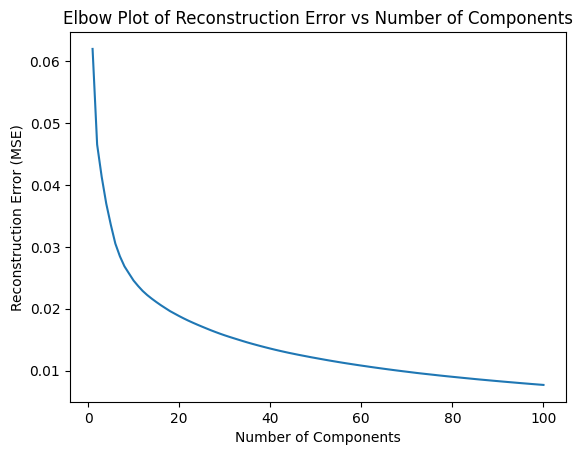

Optimal number of components (koptimal): 75


In [38]:
k_optimal, mse_errors = estimate_optimal_components(ae_train_x, ae_val_x, max_components=100)

In [39]:
def visualize_reconstructions(pca_autoencoder, X_test, num_images=10):
    X_reconstructed = pca_autoencoder.forward(X_test)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Original")

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Reconstructed")

    plt.tight_layout()
    plt.show()

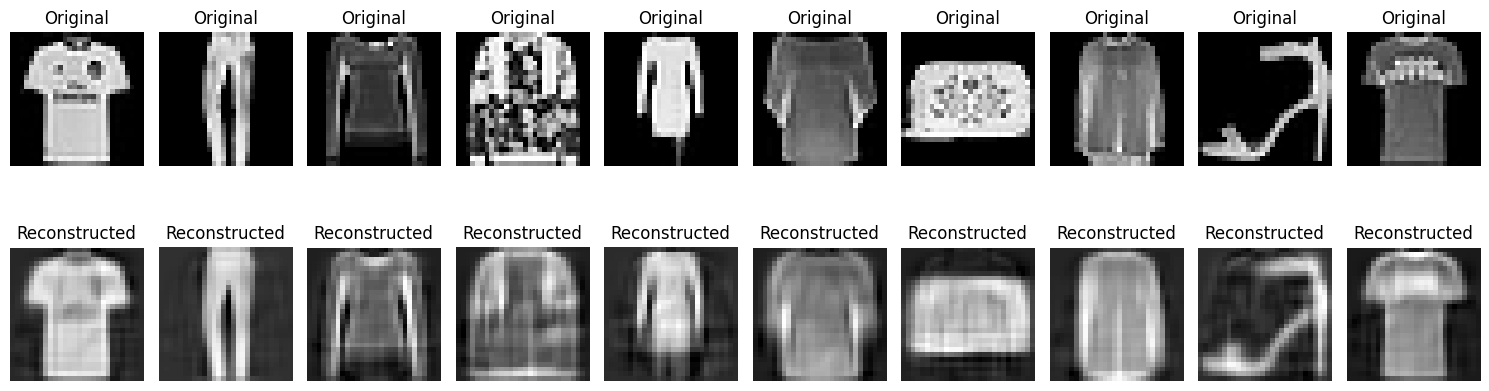

In [40]:
pca_autoencoder = PCA_autoencoder(latent_dim=k_optimal)
pca_autoencoder.fit(ae_train_x)

visualize_reconstructions(pca_autoencoder, ae_test_x[:10])

### KNN Classification